## **MODEL LSTM**

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the dataset
url = 'https://raw.githubusercontent.com/C4AnN/Models/main/Laptop%20Lens%20Model%20LSTM/Model%20%2B%20Id_barang/Data%20_Barang%20_Keluar_Update.csv'
store_sales = pd.read_csv(url)
store_sales['date'] = pd.to_datetime(store_sales['date'])

# Function to categorize price
def categorize_price(price):
    if price < 8000000:
        return 'low'
    elif 8000000 <= price < 16000000:
        return 'mid'
    else:
        return 'high'

# Categorize price and clean data
store_sales['category'] = store_sales['price'].apply(categorize_price)
store_sales = store_sales.drop(['id_barang', 'name', 'price'], axis=1)

# Function to process each category
def process_category(data, category_name, window_size):
    data = data[data['category'] == category_name].drop(['category'], axis=1)
    data['date'] = data['date'].dt.to_period("W-SUN").dt.to_timestamp()

    weekly_sales = data.groupby('date').sum().reset_index()

    print(f"\nCategory: {category_name}")
    print(f"Weekly sales data shape: {weekly_sales.shape}")

    # Calculate sales difference
    weekly_sales['sales_diff'] = weekly_sales['sales'].diff()
    weekly_sales = weekly_sales.dropna()
    print(f"Weekly sales data after differencing shape: {weekly_sales.shape}")

    # Determine appropriate window size based on available data
    available_data_length = weekly_sales.shape[0]
    adjusted_window_size = min(window_size, available_data_length - 1)
    print(f"Adjusted window size: {adjusted_window_size}")

    # Prepare supervised data with the adjusted window size
    supervised_data = weekly_sales.drop(['date', 'sales'], axis=1)
    for i in range(1, adjusted_window_size + 1):
        col_name = 'week_' + str(i)
        supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
    supervised_data = supervised_data.dropna().reset_index(drop=True)
    print(f"Supervised data shape: {supervised_data.shape}")

    train_data = supervised_data[:-8]
    test_data = supervised_data[-4:]
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Scale the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data)
    train_data_scaled = scaler.transform(train_data)
    test_data_scaled = scaler.transform(test_data)

    X_train, y_train = train_data_scaled[:, 1:], train_data_scaled[:, 0]
    X_test, y_test = test_data_scaled[:, 1:], test_data_scaled[:, 0]

    # Reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], 1)))
    model.add(LSTM(200, activation='tanh', return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(100, activation='tanh'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Setup callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

    # Save the model architecture to JSON and weights to HDF5
    model_json = model.to_json()
    with open(f'best_model_{category_name}.json', 'w') as json_file:
        json_file.write(model_json)
    model.save_weights(f'best_model_weights_{category_name}.weights.h5')

    # Make predictions
    lstm_pre = model.predict(X_test)

    # Prepare prediction DataFrame
    sales_dates = weekly_sales['date'][-4:].reset_index(drop=True)
    predict_df = pd.DataFrame(sales_dates, columns=['date'])

    act_sales = weekly_sales['sales'][-5:].to_list()
    lstm_pre = lstm_pre.reshape(-1, 1)
    lstm_pre_test_set = np.concatenate([lstm_pre, X_test.reshape((X_test.shape[0], X_test.shape[1]))], axis=1)
    lstm_pre_test_set = scaler.inverse_transform(lstm_pre_test_set)

    result_list = []
    for index in range(0, len(lstm_pre_test_set)):
        result_list.append(lstm_pre_test_set[index][0] + act_sales[index + 1])
    lstm_pre_series = pd.Series(result_list, name="LSTM Prediction")
    predict_df = predict_df.merge(lstm_pre_series, left_index=True, right_index=True)

    # Predict next 4 weeks (approximately 1 month)
    future_predictions = []
    last_data = supervised_data[-1:].copy()

    for _ in range(4):
        last_data_scaled = scaler.transform(last_data)
        X_last = last_data_scaled[:, 1:].reshape((1, X_train.shape[1], 1))
        next_pred = model.predict(X_last)[0, 0]

        future_pred = np.concatenate([[next_pred], last_data_scaled[0, 1:]])
        future_pred = scaler.inverse_transform([future_pred])

        future_predictions.append(future_pred[0][0] + weekly_sales['sales'].iloc[-1])

        new_row = np.append([next_pred], last_data.values[0, :-1])
        last_data = pd.DataFrame([new_row], columns=supervised_data.columns)

    future_dates = pd.date_range(start=weekly_sales['date'].iloc[-1] + pd.DateOffset(weeks=1), periods=4, freq='W-SUN')
    future_df = pd.DataFrame({'date': future_dates, 'LSTM Prediction': future_predictions})

    return weekly_sales, predict_df, future_df, model

# Process and predict for each category using window size of 12 weeks (3 months)
window_size = 12

categories = ['low', 'mid', 'high']
results = {}

for category in categories:
    weekly_sales, predict_df, future_df, model = process_category(store_sales, category, window_size)
    if model is not None:
        results[category] = {
            'weekly_sales': weekly_sales,
            'predict_df': predict_df,
            'future_df': future_df,
            'model': model
        }
        model_json = model.to_json()
        with open(f'best_model_{category}.json', 'w') as json_file:
            json_file.write(model_json)
        model.save_weights(f'best_model_weights_{category}.weights.h5')
    else:
        print(f"Skipping category {category} due to insufficient data.")



Category: low
Weekly sales data shape: (261, 2)
Weekly sales data after differencing shape: (260, 3)
Adjusted window size: 12
Supervised data shape: (248, 13)
Train data shape: (240, 13)
Test data shape: (4, 13)
Epoch 1/200
15/15 [==============================] - 6s 126ms/step - loss: 0.1111 - val_loss: 0.2395
Epoch 2/200
15/15 [==============================] - 0s 31ms/step - loss: 0.1105 - val_loss: 0.2025
Epoch 3/200
15/15 [==============================] - 0s 31ms/step - loss: 0.1096 - val_loss: 0.2066
Epoch 4/200
15/15 [==============================] - 1s 35ms/step - loss: 0.1064 - val_loss: 0.2119
Epoch 5/200
15/15 [==============================] - 1s 36ms/step - loss: 0.1062 - val_loss: 0.2395
Epoch 6/200
15/15 [==============================] - 0s 31ms/step - loss: 0.1075 - val_loss: 0.2193
Epoch 7/200
15/15 [==============================] - 0s 31ms/step - loss: 0.1069 - val_loss: 0.2416
Epoch 8/200
15/15 [==============================] - 0s 31ms/step - loss: 0.1054 - val

1/1 [==============================] - 0s 23ms/step

Category: mid
Weekly sales data shape: (261, 2)
Weekly sales data after differencing shape: (260, 3)
Adjusted window size: 12
Supervised data shape: (248, 13)
Train data shape: (240, 13)
Test data shape: (4, 13)
Epoch 1/200
15/15 [==============================] - 6s 136ms/step - loss: 0.1265 - val_loss: 0.0398
Epoch 2/200
15/15 [==============================] - 1s 36ms/step - loss: 0.1175 - val_loss: 0.0388
Epoch 3/200
15/15 [==============================] - 1s 36ms/step - loss: 0.1178 - val_loss: 0.0394
Epoch 4/200
15/15 [==============================] - 1s 38ms/step - loss: 0.1181 - val_loss: 0.0382
Epoch 5/200
15/15 [==============================] - 1s 36ms/step - loss: 0.1180 - val_loss: 0.0375
Epoch 6/200
15/15 [==============================] - 1s 38ms/step - loss: 0.1177 - val_loss: 0.0386
Epoch 7/200
15/15 [==============================] - 1s 36ms/step - loss: 0.1157 - val_loss: 0.0423
Epoch 8/200
15/15 [===============

## **VISUALISASI DATA**

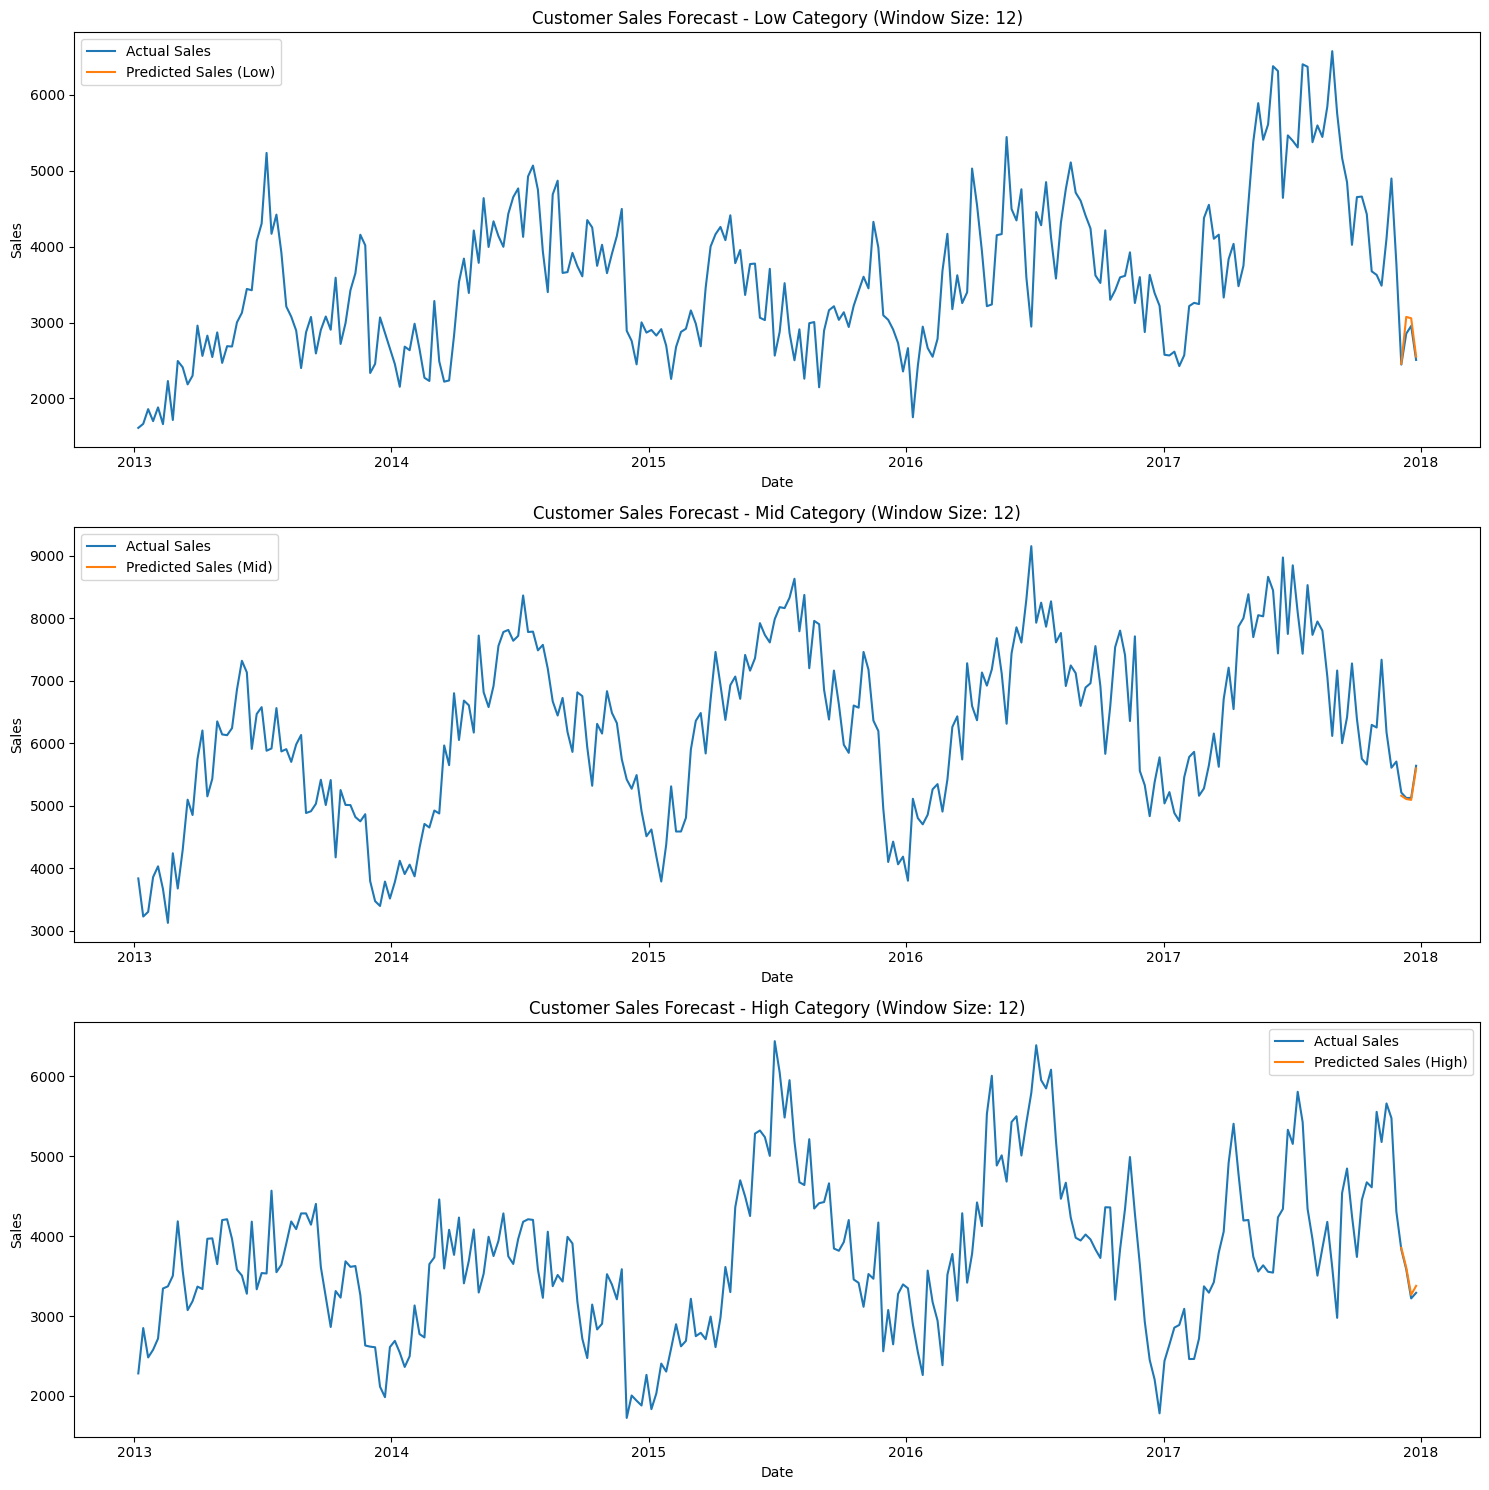

In [7]:
# Plot predictions by category
plt.figure(figsize=(15, 15))

if 'low' in results:
    low_sales = results['low']['weekly_sales']
    low_predict_df = results['low']['predict_df']
    # Low category plot
    plt.subplot(3, 1, 1)
    plt.plot(low_sales['date'], low_sales['sales'], label='Actual Sales')
    plt.plot(low_predict_df['date'], low_predict_df['LSTM Prediction'], label='Predicted Sales (Low)')
    plt.title("Customer Sales Forecast - Low Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping Low category plot due to insufficient data.")

if 'mid' in results:
    mid_sales = results['mid']['weekly_sales']
    mid_predict_df = results['mid']['predict_df']
    # Mid category plot
    plt.subplot(3, 1, 2)
    plt.plot(mid_sales['date'], mid_sales['sales'], label='Actual Sales')
    plt.plot(mid_predict_df['date'], mid_predict_df['LSTM Prediction'], label='Predicted Sales (Mid)')
    plt.title("Customer Sales Forecast - Mid Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping Mid category plot due to insufficient data.")

if 'high' in results:
    high_sales = results['high']['weekly_sales']
    high_predict_df = results['high']['predict_df']
    # High category plot
    plt.subplot(3, 1, 3)
    plt.plot(high_sales['date'], high_sales['sales'], label='Actual Sales')
    plt.plot(high_predict_df['date'], high_predict_df['LSTM Prediction'], label='Predicted Sales (High)')
    plt.title("Customer Sales Forecast - High Category (Window Size: 12)")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
else:
    print("Skipping High category plot due to insufficient data.")

plt.tight_layout()
plt.show()


## **LOAD DATA JSON**

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import model_from_json

# Function to load model from JSON and weights from HDF5
def load_model_from_json(json_path, weights_path):
    with open(json_path, 'r') as json_file:
        model_json = json_file.read()
    model = model_from_json(model_json)
    model.load_weights(weights_path)
    return model

# Load models for each category
loaded_model_low = load_model_from_json('best_model_low.json', 'best_model_weights_low.weights.h5')
loaded_model_mid = load_model_from_json('best_model_mid.json', 'best_model_weights_mid.weights.h5')
loaded_model_high = load_model_from_json('best_model_high.json', 'best_model_weights_high.weights.h5')

# Function to categorize price
def categorize_price(price):
    if price <= 8000000:
        return 'low'
    elif 8000000 < price <= 16000000:
        return 'mid'
    else:
        return 'high'

# Function to make prediction for next week with a fixed window size
def predict_next_week_sales(data, model, window_size=12):
    weekly_sales = data.resample('W', on='date').sum()  # Resample to weekly data

    # Prepare input data for prediction
    sales_data = np.array(weekly_sales['sales'])

    # Ensure input data has the correct window size
    if len(sales_data) < window_size:
        # If there are fewer data points than the window size, pad with zeros
        input_data = np.pad(sales_data, (window_size - len(sales_data), 0), mode='constant')
    else:
        # Otherwise, take the last 'window_size' data points
        input_data = sales_data[-window_size:]

    input_data = input_data.reshape((1, window_size, 1))

    # Scale the input data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(input_data.reshape(-1, 1))
    input_data_scaled = scaler.transform(input_data.reshape(-1, 1)).reshape((1, window_size, 1))

    # Make prediction
    predicted_sales_scaled = model.predict(input_data_scaled)

    # Inverse transform to get actual sales value
    predicted_sales_actual = scaler.inverse_transform(predicted_sales_scaled.reshape(-1, 1))

    return predicted_sales_actual[-1][0]

# Load new data from CSV file
new_data_url = 'https://raw.githubusercontent.com/C4AnN/Models/main/Laptop%20Lens%20Model%20LSTM/Model%20%2B%20Id_barang/Dataset_Bulan_Desember_2017.csv'
new_data = pd.read_csv(new_data_url)

# Ensure 'date' column is in datetime format
new_data['date'] = pd.to_datetime(new_data['date'])

# Add category column to new_data based on price
new_data['category'] = new_data['price'].apply(categorize_price)

# Filter data for each category
new_data_low = new_data[new_data['category'] == 'low'].copy()
new_data_mid = new_data[new_data['category'] == 'mid'].copy()
new_data_high = new_data[new_data['category'] == 'high'].copy()

# Predict sales for next week for each category
predicted_sales_low = predict_next_week_sales(new_data_low, loaded_model_low)
predicted_sales_mid = predict_next_week_sales(new_data_mid, loaded_model_mid)
predicted_sales_high = predict_next_week_sales(new_data_high, loaded_model_high)

# Output predictions
print("Prediksi penjualan untuk minggu berikutnya (Low Category):", int(predicted_sales_low), "units")
print("Prediksi penjualan untuk minggu berikutnya (Mid Category):", int(predicted_sales_mid), "units")
print("Prediksi penjualan untuk minggu berikutnya (High Category):", int(predicted_sales_high), "units")


1/1 [==============================] - 1s 860ms/step
Prediksi penjualan untuk minggu berikutnya (Low Category): 1771 units
Prediksi penjualan untuk minggu berikutnya (Mid Category): 3895 units
Prediksi penjualan untuk minggu berikutnya (High Category): 2641 units


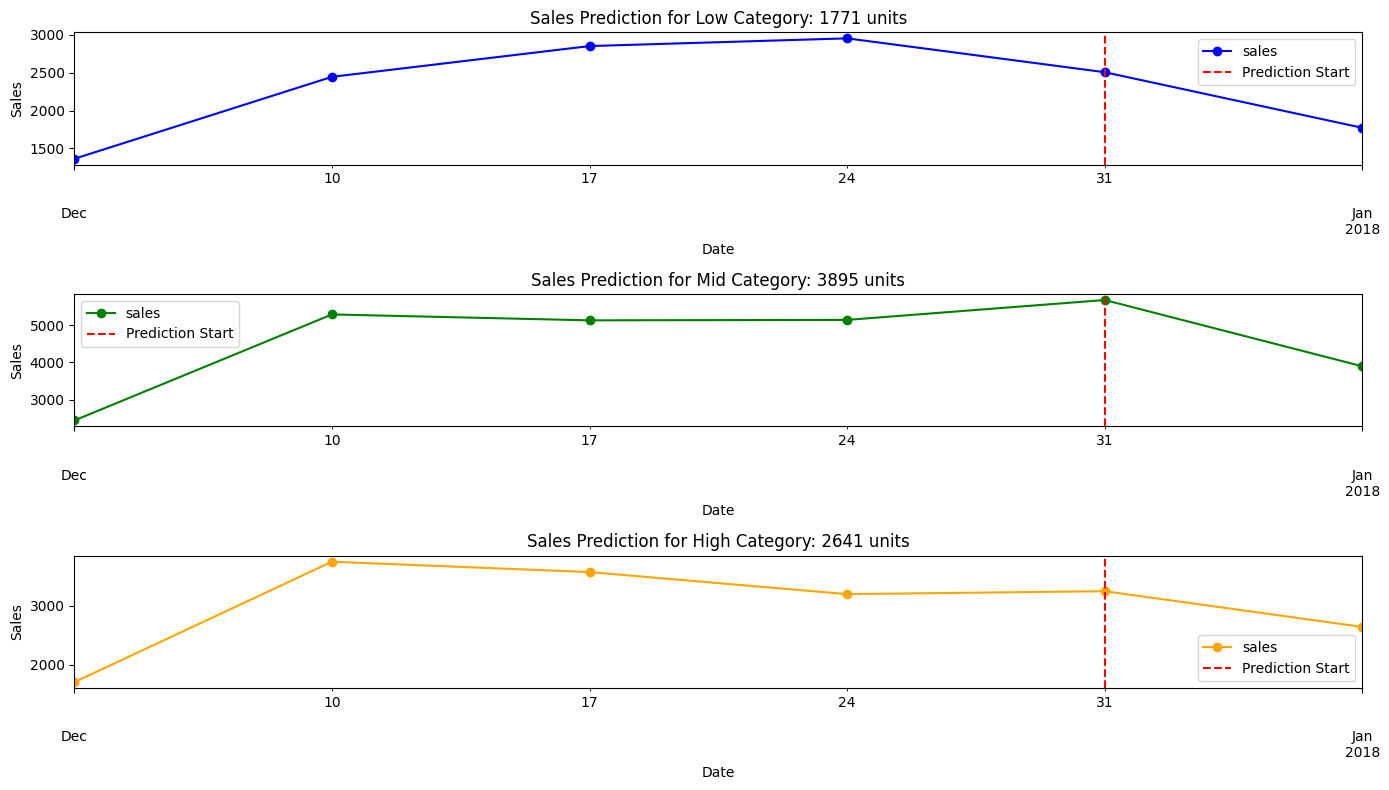

In [9]:
# Prepare data for plotting for the last 6 months
def prepare_plot_data_last_6_months(data, predicted_sales, category_name):
    data['date'] = pd.to_datetime(data['date'])
    weekly_sales = data.resample('W', on='date').sum()

    # Filter data for the last 6 months
    last_6_months_sales = weekly_sales.iloc[-24:]  # Assuming 4 weeks per month
    last_date = last_6_months_sales.index[-1]
    next_week_date = last_date + pd.DateOffset(weeks=1)

    # Create a DataFrame for plotting
    plot_data = last_6_months_sales['sales'].copy()
    plot_data[next_week_date] = predicted_sales

    return plot_data

# Prepare data for each category for the last 6 months
plot_data_low = prepare_plot_data_last_6_months(new_data_low, predicted_sales_low, 'low')
plot_data_mid = prepare_plot_data_last_6_months(new_data_mid, predicted_sales_mid, 'mid')
plot_data_high = prepare_plot_data_last_6_months(new_data_high, predicted_sales_high, 'high')

# Plot the data
plt.figure(figsize=(14, 8))

# Plot for low category
plt.subplot(3, 1, 1)
plot_data_low.plot(marker='o', color='blue', title=f'Sales Prediction for Low Category: {int(predicted_sales_low)} units')
plt.axvline(plot_data_low.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for mid category
plt.subplot(3, 1, 2)
plot_data_mid.plot(marker='o', color='green', title=f'Sales Prediction for Mid Category: {int(predicted_sales_mid)} units')
plt.axvline(plot_data_mid.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for high category
plt.subplot(3, 1, 3)
plot_data_high.plot(marker='o', color='orange', title=f'Sales Prediction for High Category: {int(predicted_sales_high)} units')
plt.axvline(plot_data_high.index[-2], color='red', linestyle='--', label='Prediction Start')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Sales')

plt.tight_layout()
plt.show()
